# Web Application Deployment

In [10]:
!pip install anvil-uplink

  Using cached https://files.pythonhosted.org/packages/7d/f4/7e1ff2590221527e46c33de1b67120e3f5f6f39693227df16d0fe681c657/anvil_uplink-0.3.22-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/94/3af39d34be01a24a6e65433d19e107099374224905f1e0cc6bbe1fd22a2f/argparse-1.4.0-py2.py3-none-any.whl


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\tables\\__init__.py'
Consider using the `--user` option or check the permissions.



In [24]:
import keras
from keras.models import load_model
import os
import anvil.media
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences

In [12]:
retModelDir = '/Users/adara/CAPSTONEPROJECT/DiabeticRetinopathy'
eyeNetBotDir = '/Users/adara/CAPSTONEPROJECT/eyeNetBot'
wordVocabDir = '/Users/adara/CAPSTONEPROJECT/eyeNetBot'

In [13]:
model = load_model('/Users/adara/CAPSTONEPROJECT/DiabeticRetinopathy/modelRet.h5')
chatModel = load_model('/Users/adara/CAPSTONEPROJECT/eyeNetBot/chatModel.h5')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
import pickle
vocab = pickle.load(open(os.path.join(wordVocabDir, "vocab.pkl"), "rb"))
stop_words = pickle.load(open(os.path.join(wordVocabDir, "stop_words.pkl"), "rb"))
word_idx = pickle.load(open(os.path.join(wordVocabDir, "word_idx.pkl"), "rb"))

In [15]:
import anvil.server

anvil.server.connect("35KHU4CLLVXFT6LWX4G34K5F-5RJCZTHEBWY35MGS")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK


#### For Diabetic Retinopathy Prediction

In [ ]:
import anvil.media
import numpy as np
from keras.preprocessing import image
@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = load_img(filename)
        
    img = img.resize((150,150), resample=PIL.Image.BICUBIC)
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr /= 255.0
    
    score = model.predict(arr)
    
    return score

In [26]:
import anvil.media
@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = image.load_img(filename, target_size=(150,150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    
    score = model.predict(img_tensor)
    
    return score, np.argmax(score)


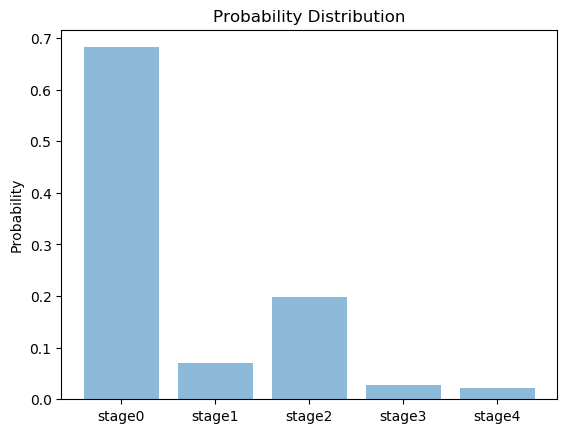

In [36]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('stage0', 'stage1', 'stage2', 'stage3', 'stage4')
y_pos = np.arange(len(objects))
performance = list(classify_image('11854_right.jpeg')[0])

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Probability')
plt.title('Probability Distribution')

plt.show()

In [19]:
from nltk.corpus import stopwords
import numpy as np
import re
import random
import os
import time
import json
import nltk
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

In [20]:
def vectorize(data):
    inputs = []
    wrds = nltk.word_tokenize(data)
    words = [stemmer.stem(w.lower()) for w in wrds if w != "?"]
    filtered_sentence = [w for w in words if not w in stop_words]
    [filtered_sentence.pop(i) for i, w in enumerate(filtered_sentence) if w not in vocab]
    
    inner_list = []
    
    for ent in filtered_sentence:
        inner_list.append(word_idx[ent])
    inputs.append(inner_list)
    
    return pad_sequences(inputs, maxlen = 8)

#### For eyeNetChatBot

In [22]:
@anvil.server.callable
def chat(inp):

    if inp.lower() == "quit":
        return 'bye'
    
    inp = vectorize(inp)
    results = model_1.predict(inp, 12)[0]
    results_index = np.argmax(results)
    output = labels[results_index]

    if results[results_index] > 0.7:
        for tg in data["intents"]:
            if tg['tag'] == output:
                responses = tg['responses']
        return random.choice(responses)
    else:
        # create a database and store the question
        return "I didn't understand that, try again."